### Video Understanding with Qwen2.5-VL

In this notebook, we delve into the capabilities of the **Qwen2.5-VL** model for video understanding tasks. Our objective is to showcase how this advanced model can be applied to various video analysis scenarios, ranging from basic OCR to complex event detection and summarization.


#### \[Setup\]

We start by loading the pre-trained `Qwen2_5_VLForConditionalGeneration` model. This model has been fine-tuned on a diverse set of video understanding tasks, enabling it to generate detailed and accurate descriptions based on visual inputs.


In [6]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
from IPython.display import Markdown, display

from utils.inference import inference
from utils.video_preprocessing import get_video_frames, create_image_grid

In [21]:

# model_path = "Qwen/Qwen2.5-VL-7B-Instruct"
model_path = "Qwen/Qwen2.5-VL-72B-Instruct"
# model_path = "Qwen/Qwen2.5-VL-32B-Instruct"
# model_path = "Qwen/Qwen2.5-VL-3B-Instruct-AWQ"
# model_path = "Qwen/Qwen2.5-VL-32B-Instruct-AWQ"


model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_path)

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00038.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00002-of-00038.safetensors:   0%|          | 0.00/3.81G [00:00<?, ?B/s]

model-00003-of-00038.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00004-of-00038.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00005-of-00038.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00006-of-00038.safetensors:   0%|          | 0.00/3.81G [00:00<?, ?B/s]

model-00007-of-00038.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00008-of-00038.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00009-of-00038.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00010-of-00038.safetensors:   0%|          | 0.00/3.81G [00:00<?, ?B/s]

model-00011-of-00038.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

model-00012-of-00038.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

OSError: [Errno 28] No space left on device

Load video frames and timestamps

In [ ]:
# !pip install decord

In [4]:
# check model is already on cuda
current_device = next(model.parameters()).device
target_device = torch.device('cuda')

if current_device != target_device:
    print("Model is not on cuda, moving to cuda")
    model = model.to(target_device)

Model is not on cuda, moving to cuda


In [9]:
# import os
# import math
# import hashlib
# import requests

# from IPython.display import Markdown, display
# import numpy as np
# from PIL import Image
# import decord
# from decord import VideoReader, cpu


# def download_video(url, dest_path):
#     response = requests.get(url, stream=True)
#     with open(dest_path, 'wb') as f:
#         for chunk in response.iter_content(chunk_size=8096):
#             f.write(chunk)
#     print(f"Video downloaded to {dest_path}")


# def get_video_frames(video_path, num_frames=128, cache_dir='.cache'):
#     os.makedirs(cache_dir, exist_ok=True)

#     video_hash = hashlib.md5(video_path.encode('utf-8')).hexdigest()
#     if video_path.startswith('http://') or video_path.startswith('https://'):
#         video_file_path = os.path.join(cache_dir, f'{video_hash}.mp4')
#         if not os.path.exists(video_file_path):
#             download_video(video_path, video_file_path)
#     else:
#         video_file_path = video_path

#     frames_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_frames.npy')
#     timestamps_cache_file = os.path.join(cache_dir, f'{video_hash}_{num_frames}_timestamps.npy')

#     if os.path.exists(frames_cache_file) and os.path.exists(timestamps_cache_file):
#         frames = np.load(frames_cache_file)
#         timestamps = np.load(timestamps_cache_file)
#         return video_file_path, frames, timestamps

#     vr = VideoReader(video_file_path, ctx=cpu(0))
#     total_frames = len(vr)

#     indices = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)
#     frames = vr.get_batch(indices).asnumpy()
#     timestamps = np.array([vr.get_frame_timestamp(idx) for idx in indices])

#     np.save(frames_cache_file, frames)
#     np.save(timestamps_cache_file, timestamps)
    
#     return video_file_path, frames, timestamps


# def create_image_grid(images, num_columns=8):
#     pil_images = [Image.fromarray(image) for image in images]
#     num_rows = math.ceil(len(images) / num_columns)

#     img_width, img_height = pil_images[0].size
#     grid_width = num_columns * img_width
#     grid_height = num_rows * img_height
#     grid_image = Image.new('RGB', (grid_width, grid_height))

#     for idx, image in enumerate(pil_images):
#         row_idx = idx // num_columns
#         col_idx = idx % num_columns
#         position = (col_idx * img_width, row_idx * img_height)
#         grid_image.paste(image, position)

#     return grid_image


Inference function

In [10]:
# def inference(video_path, prompt, max_new_tokens=2048, total_pixels=20480 * 28 * 28, min_pixels=16 * 28 * 28):
#     messages = [
#         {"role": "system", "content": "You are a helpful assistant."},
#         {"role": "user", "content": [
#                 {"type": "text", "text": prompt},
#                 {"video": video_path, "total_pixels": total_pixels, "min_pixels": min_pixels},
#             ]
#         },
#     ]
#     text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
#     image_inputs, video_inputs, video_kwargs = process_vision_info([messages], return_video_kwargs=True)
#     fps_inputs = video_kwargs['fps']
#     print("video input:", video_inputs[0].shape)
#     num_frames, _, resized_height, resized_width = video_inputs[0].shape
#     print("num of video tokens:", int(num_frames / 2 * resized_height / 28 * resized_width / 28))
#     inputs = processor(text=[text], images=image_inputs, videos=video_inputs, fps=fps_inputs, padding=True, return_tensors="pt")
#     inputs = inputs.to('cuda')

#     output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
#     generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
#     output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
#     return output_text[0]

Inference function with API using OpenAI SDK.

**Important Notice:**
- Please be aware that the current API supports video processing up to a maximum length of 10 minutes.
- Currently, the model inference interface does not support configuring the resolution of video frames. Therefore, it is recommended to resize videos with higher resolutions and longer durations to a smaller resolution to ensure that the input sequence is not excessively long. We advise keeping the number of video tokens under 24k to achieve better video grounding results.

## inference with grid

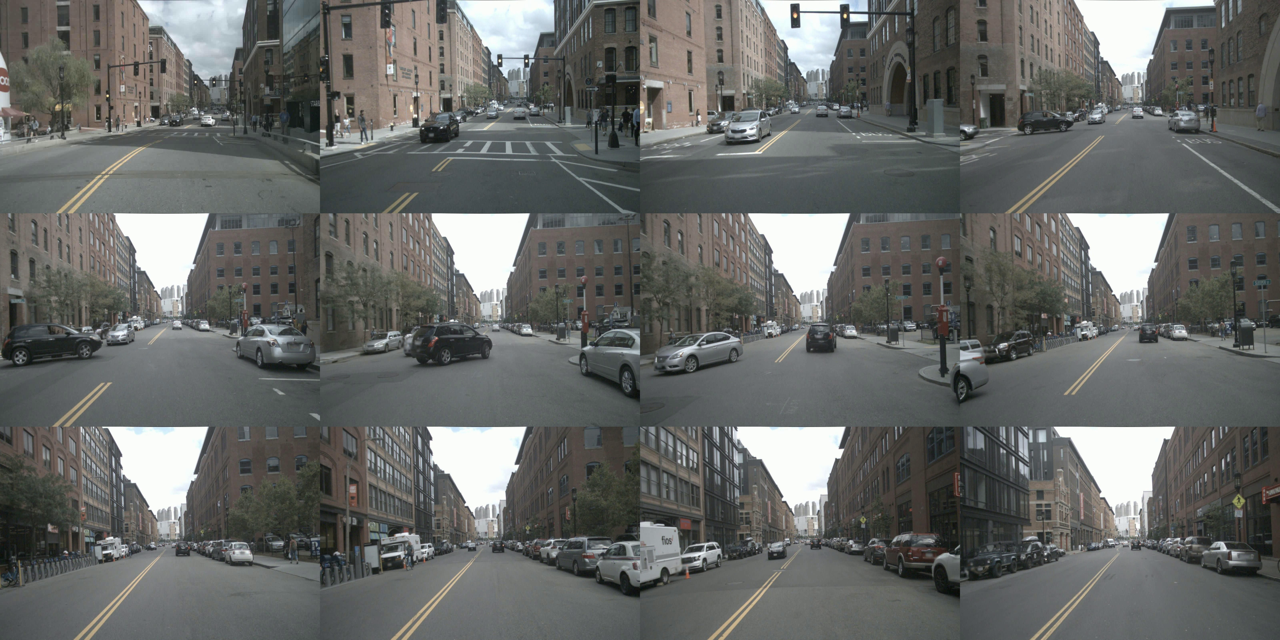

video input: torch.Size([30, 3, 560, 1008])
num of video tokens: 10800


The event "other vehicle did lane changes into the lane in front me and I have to decelerate" happens in 00:00.00 - 00:05.00.

In [20]:
video_path = "/root/Qwen2.5-VL/cookbooks/videos/n008-2018-08-01-15-16-36-0400.mp4"
prompt = "Give the query: 'other vehicle did lane changes into the lane in front of me and I have to decelerate', when does the described content occur in the video? Output the start and end timestamp for each event, use ‘mm:ss.ff’ as time format."

video_path, frames, timestamps = get_video_frames(video_path, num_frames=12)
image_grid = create_image_grid(frames, num_columns=4)
display(image_grid.resize((1280, 640)))

response = inference(model, processor, video_path, prompt)
display(Markdown(response))


# inference with api

In [20]:
# import os
# from openai import OpenAI
# from IPython.display import Markdown, display


# def inference_with_api(
#     video_path,
#     prompt,
#     sys_prompt = "You are a helpful assistant.",
#     model_id = "qwen-vl-max-latest",
# ):
#     client = OpenAI(
#         api_key = os.getenv('DASHSCOPE_API_KEY'),
#         base_url = "https://dashscope.aliyuncs.com/compatible-mode/v1",
#     )    
#     messages = [
#         {
#             "role": "system",
#             "content": [{"type":"text","text": sys_prompt}]
#         },
#         {
#             "role": "user",
#             "content": [
#                 {"type": "video_url", "video_url": {"url": video_path}},
#                 {"type": "text", "text": prompt},
#             ]
#         }
#     ]
#     completion = client.chat.completions.create(
#         model = model_id,
#         messages = messages,
#     )
#     print(completion)
#     return completion.choices[0].message.content

#### 1. Reading Text in Videos

In this section, we demonstrate how the model can be used to recognize and summarize text within a video. Specifically, we'll use a video containing various products and ask the model to summarize their characteristics in a structured format.


In [ ]:
video_url = "https://duguang-labelling.oss-cn-shanghai.aliyuncs.com/qiansun/video_ocr/videos/50221078283.mp4"
prompt = "请用表格总结一下视频中的商品特点"

## Use a local HuggingFace model to inference.
video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
# image_grid = create_image_grid(frames, num_columns=8)
# display(image_grid.resize((640, 640)))

response = inference(video_path, prompt)
display(Markdown(response))

In [ ]:
## Use API for inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 

video_url = "http://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/cookbook/video_ocr.mp4"
prompt = "Watch the video and list the paper titles in a table, add one extra column for translating the paper titles to Chinese."

response = inference_with_api(video_url, prompt)
display(Markdown(response))

#### 2. Long Video Understanding

Next, we explore the model's capability to comprehend extremely long videos, such as those lasting up to one hour. This demonstrates how the model can effectively process and analyze extended video content, extracting meaningful insights over longer durations.

To reduce the number of visual tokens generated from a long video, you can specify the `resized_height` and `resized_width` parameters. These settings allow the video frames to be resized to a smaller dimension, effectively decreasing the computational load while maintaining the essential visual information needed for analysis.


In [ ]:
video_url = "https://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/evaluations/data/LVBench/videos/GcRKREorGSc.mp4"
prompt = "Could you go into detail about the content of this long video?"

video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
# image_grid = create_image_grid(frames, num_columns=8)
# display(image_grid.resize((640, 640)))

response = inference(video_path, prompt)
display(Markdown(response))


#### 3. Video Grounding

This part focuses on answering specific questions about a video segment. We specify a textual query and ask the model what is the period that the described content occur in the video, showcasing the model's ability to understand timestamps and search the detailed queries.

In [ ]:
video_url = "https://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/datasets/cookbook/ead2e3f0e7f836c9ec51236befdaf2d843ac13a6.mp4"
prompt = "Give the query: 'seasoning the steak', when does the described content occur in the video?"

video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
image_grid = create_image_grid(frames, num_columns=8)
display(image_grid.resize((640, 640)))

# inference
response = inference(video_path, prompt)
display(Markdown(response))

In [ ]:
## Use API for inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 

video_url = "http://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/cookbook/video_structured_caption_480p.mov"
prompt = "Give the query: 'The seasoned meat is placed on a grill', when does the described content occur in the video? Use ‘mm:ss.ff’ as time format."

response = inference_with_api(video_url, prompt)
display(Markdown(response))

#### 4. Structured Video Captioning

Finally, we present a scenario where the model identifies significant events within the video, providing start and end timestamps for each event along with descriptive sentences. The output is formatted in JSON for easy parsing and further processing.


In [20]:
video_url = "https://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/datasets/cookbook/ead2e3f0e7f836c9ec51236befdaf2d843ac13a6.mp4"
prompt = "Localize a series of activity events in the video, output the start and end timestamp for each event, and describe each event with sentences. Provide the result in json format with 'mm:ss.ff' format for time depiction."

video_path, frames, timestamps = get_video_frames(video_url, num_frames=64)
# image_grid = create_image_grid(frames, num_columns=8)
# display(image_grid.resize((640, 640)))

In [ ]:
# inference
response = inference(video_path, prompt)
display(Markdown(response))

- By post-processing the json results, we can intuitively present video clips and descriptions in an interleaved manner.

In [22]:
import json
import markdown
from bs4 import BeautifulSoup
from datetime import datetime


def parse_json(response):
    html = markdown.markdown(response, extensions=['fenced_code'])
    soup = BeautifulSoup(html, 'html.parser')
    json_text = soup.find('code').text

    data = json.loads(json_text)
    return data


def time_to_seconds(time_str):
    time_obj = datetime.strptime(time_str, '%M:%S.%f')
    total_seconds = time_obj.minute * 60 + time_obj.second + time_obj.microsecond / 1_000_000
    return total_seconds


In [ ]:
data = parse_json(response)

for item in data:
    start_time = item["start_time"]
    end_time = item["end_time"]
    description = item["description"]

    display(Markdown(f"**{start_time} - {end_time}:**\t\t" + description))

    start_time = time_to_seconds(start_time)
    end_time = time_to_seconds(end_time)
    current_frames = []
    for frame, timestamp in zip(frames, timestamps):
        if timestamp[0] > start_time and timestamp[1] < end_time:
            current_frames.append(frame)
    
    current_frames = np.array(current_frames)
    current_image_grid = create_image_grid(current_frames, num_columns=8)

    display(current_image_grid.resize((480, (int(len(current_frames) / 8) + 1) * 60)))


In [ ]:
## Use API for inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here' 

video_url = "http://ofasys-multimodal-wlcb-3.oss-cn-wulanchabu.aliyuncs.com/sibo.ssb/cookbook/video_structured_caption_480p.mov"
prompt = "Localize a series of activity events in the video, output the start and end timestamp for each event, and describe each event with sentences. Provide the result in json format with ‘mm:ss.ff’ format for time depiction."

response = inference_with_api(video_url, prompt)
display(Markdown(response))